# Workshop Content

This notebook contains the workflow for produceding a geodemographic classification in python using k-means clustering. It follows a process similar to that described in the 2021 OAC Paper [@2021_oac].


* **Data Access and Processing:**
    * Access UK census data and process using Pandas

* **Census Data Analysis and Variable selection:**
    * Perform correlation analysis to identify redundant variables
    * Use PCA (Principal Component Analysis) to reduce dimensionality and identify key components
    * Select variables based on explained variance and interpretability

* **Clustering:**
    * Apply K-Means clustering to classify areas based on selected variables
    * Determine optimal number of clusters using Clustergrams
    * Perform hierarchical clustering to group clusters into supergroups
    * Conduct subclustering within supergroups to identify finer patterns

* **Advanced Analytical Techniques:**
    * Use UMAP (Uniform Manifold Approximation and Projection) to visualise high-dimensional embeddings in 2D

* **Visualisation and Communication:**
    * Visualise clusters and subclusters using Kepler.gl for interactive mapping
    * Export results to various formats (GeoPackage, Parquet) for use in GIS software
    * Generate publication-ready plots and statistical summaries

In [1]:
#| output: false
#| echo: false
print("This code will not be displayed, nor the output")

This code will not be displayed, nor the output


# What are Geodemographics?

Geodemographics is a method of classifying geographic areas based on the characteristics of their populations. It involves grouping areas with similar demographic, socio-economic, and lifestyle attributes into distinct categories or clusters. These classifications help in understanding the spatial distribution of different population segments and are widely used in various fields such as marketing, urban planning, public health, and social research.

Geodemographic classifications are typically created using statistical techniques such as cluster analysis, in particular k-means clustering. 

# Setup 


There are a number of python packages that need to be installed to run this notebook. It is recommended to use a virtual environment to manage these dependencies.

```bash
python -m venv .venv
# macOS / Linux
source .venv/bin/activate
# Windows (PowerShell)
.venv/Scripts/Activate.ps1

pip install --upgrade pip
pip install earthengine-api pandas geopandas pyarrow scikit-learn clustergram umap-learn seaborn plotly matplotlib numpy requests Pillow duckdb keplergl uvicorn
```


In [4]:
# !pip install pandas geopandas scikit-learn matplotlib seaborn umap-learn kepler.gl

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from clustergram import Clustergram
import matplotlib.pyplot as plt
import os
import geopandas as gpd
from keplergl import KeplerGl
import umap.umap_ as umap

#set a  random seed for reproducibility
random_seed = 507


/home/ogoodwin/projects/GeoDem_CartoWorkshop2025/.venv/lib/python3.12/site-packages/keplergl/keplergl.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


## Load Required Data Sets

### England and Wales Census Data
We will be building a geodemographic classification using UK Census data. The data used in this example is from the 2021 England and Wales Census which can be accessed from [England and Wales](https://www.ons.gov.uk/census/2021censusdata).
This is open data and can be downloaded freely. The data contain a variety of demographic, socio-economic, and housing variables at the Output Area (OA) level.

The data us available here:



### Output Areas
Output Areas (OAs) are the smallest geographical units availble openly in the UK Census. They are designed to have similar population sizes and are used to report census data. Each OA typically contains around 100-200 households. The boundaries of OAs are determined based on various factors, including physical

In order to map the census data, we will need the OA boundaries. These can be downloaded from the [ONS Open Geography Portal](https://geoportal.statistics.gov.uk/). 




In [3]:

#load the input data from a csv file 
# The names of the columns are not important, BUT;
# the first column should be the geography code (e.g., Output Area or Local Authority District),
# which will be used as the DataFrame index.
# The remaining columns should be variables for clustering, provided as fractions or percentages of the table total.
def load_data(filepath):
    input_df = pd.read_csv(filepath, index_col=0)
    
    # Check for missing values
    missing_values = input_df.isnull().sum().sum()
    if missing_values > 0:
        print(f"Warning: {missing_values} missing values found in input data. Missing values will be replaced with 0.")
        input_df.fillna(0, inplace=True)
    
    return input_df

# File path to the dataset
inputdata_filepath = "../input_data/Hybrid_OAC.csv"

# Load the dataset
variable_df = load_data(inputdata_filepath)

#drop "country" column
variable_df = variable_df.drop(columns=['country'])
variable_df = variable_df*100
#round to ints
variable_df = variable_df.round(0).astype(int)
#save to data/example_oacdata.csv
variable_df.to_csv('example_oacdata.csv')
#show first 5 rows of the dataset
variable_df.head()

#Print Data set shape
print(f"Input data shape: {variable_df.shape}")

Input data shape: (239768, 60)


### Selecting a Region
For this example, we will focus on a specific region to keep the analysis manageable. We will use the Output Areas within the the region of Liverpool and its surrounding areas. This region is prodominently urban and has a diverse population, making it an interesting case study for geodemographic classification.

In [4]:

#limit to OAs in Liverpool region

# --- Step 2: Load OA boundaries (parquet in EPSG:27700) ---
oas = gpd.read_parquet("../input_data/oabounds.parquet")

#set index to "OA"

oas = oas.set_index("OA")
# --- Step 4: Clip to Liverpool bounding box (EPSG:27700) ---
bbox = {
    "minx": 320000,
    "maxx": 400000,
    "miny": 377000,
    "maxy": 427000
}
oas_liv = oas.cx[bbox["minx"]:bbox["maxx"], bbox["miny"]:bbox["maxy"]]


#quick map of the area in kepler


# --- Merge OA polygons with your variable data ---
oas_liv_vars = oas_liv.join(variable_df, how="inner")

# --- Quick Kepler map ---
map_ = KeplerGl(height=600)

# Add your layer
map_.add_data(data=oas_liv_vars, name="Liverpool OAs")
# If you want to export to a standalone HTML:
map_.save_to_html(file_name="liverpool_oas_map.html")
# Show inside Jupyter
map_




User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to liverpool_oas_map.html!


KeplerGl(data={'Liverpool OAs': {'index': ['E00024141', 'E00024142', 'E00024143', 'E00024144', 'E00024145', 'E…

In [5]:
# #keeo only OAs in Liverpool
variable_df=variable_df.loc[variable_df.index.isin(oas_liv.index)]


# Transform and Standardize Data

The function below applies two transformations to a dataframe:

1. **Inverse Hyperbolic Sine (IHS) Transform**  
   - Similar to a log transform but works with zero and negative values.  
   - Helps stabilize variance and make skewed distributions more normal-like.

2. **Min-Max Scaling**  
   - Rescales all values into the range [0, 1].  
   - Useful for comparing variables with different units/scales.



In [6]:
def transform_and_standardize_data(df):
    """Apply inverse hyperbolic sine transform, to account for non-normality
      and then range standardize using min-max scaling to the dataframe."""
    df = np.arcsinh(df)
    df = (df - df.min()) / (df.max() - df.min())
    return df

# Transform the input data
transformed_variable_df = transform_and_standardize_data(variable_df)


# Variable Selection

We will use a combination of correlation analysis and Principal Component Analysis (PCA) to select a subset of variables for clustering. The goal is to reduce redundancy and focus on the most informative variables.




In [ ]:
#STUFF FROM ALEX's paper.

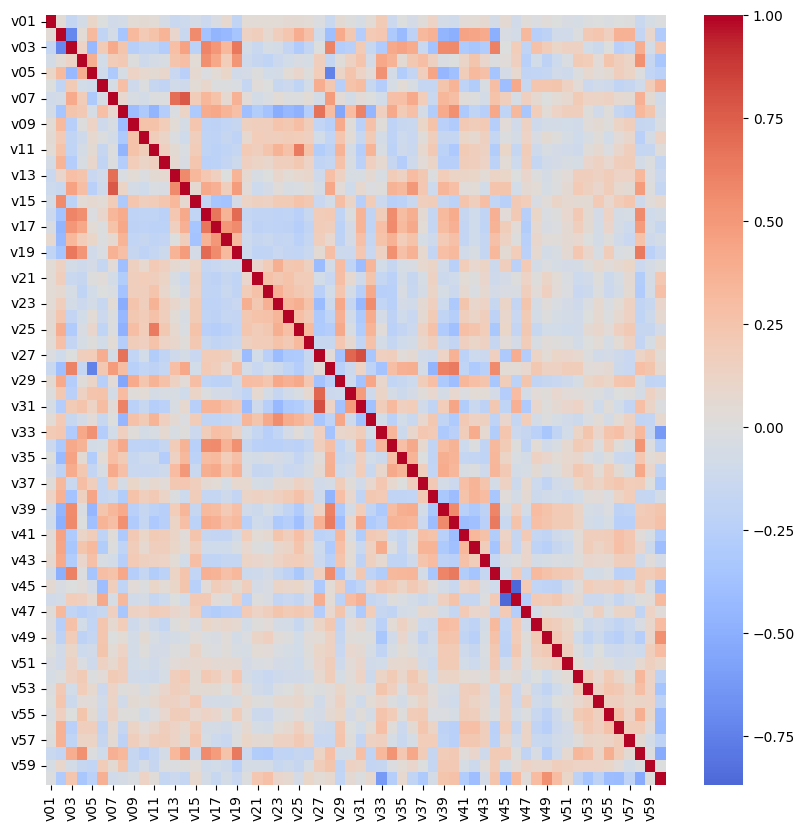

Removed columns: {'v31'}


In [7]:
import seaborn as sns

def check_corrs(df, corr_threshold = 0.9):
    # Compute the correlation matrix
    corr_matrix = df.corr()
    #plot the correlation matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.show()

    # Find the pairs of highly correlated columns
    # Create a mask to exclude the diagonal (correlation of a column with itself)
    highly_corr = np.where((corr_matrix > corr_threshold ) & (corr_matrix != 1))

    # List to keep track of columns to remove
    columns_to_remove = set()
    # Loop through the pairs and add one column to remove for each pair of high correlation
    for i, j in zip(*highly_corr):
        colname_i = corr_matrix.columns[i]
        colname_j = corr_matrix.columns[j]
        # Keep the column that has the most information or less missing data
        if colname_i not in columns_to_remove:
            columns_to_remove.add(colname_j)  # Add the second column of the pair for removal

    # Remove the columns with high correlation
    df_cleaned = df.drop(columns=columns_to_remove)
    # Show the cleaned dataframe
    print(f"Removed columns: {columns_to_remove}")
    return df_cleaned

# Check for highly correlated variables and remove them
cleaned_variable_df = check_corrs(transformed_variable_df, corr_threshold=0.8)

# K-Means Clustering


## Clustergrams
We can examine the structure the census data using a Clustergram This is a visualisation technique that shows how cluster assignments change as you increase the number of clusters (k). This helps you to understand the structure in very high-dimensional space in the following ways:

- **Optimal k selection**: Helps you to determine the right number of clusters by visualising how cleanly clusters separate  
- **Cluster stability**: Shows which clusters persist across different k values (stable long lines) vs. those which are artifacts of over-clustering (short, erratic lines)  
- **Split patterns**: Reveals the natural hierarchy in the data by showing how clusters subdivide  


From the diagram, a five cluster solutions looks to be an optimal initial choice

Further guidance on interpreting clustergrams and choosing the number of clusters can be found here:  [Clustergram](https://clustergram.readthedocs.io/en/stable/notebooks/introduction.html)

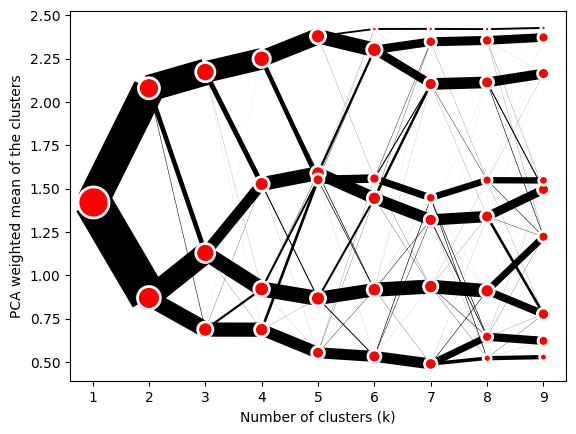

In [11]:

def create_clustergram(df, n_init, save_loc, random_seed=random_seed):
    """
    Create and save a clustergram for evaluating k-means clustering solutions.

    The clustergram visualizes clustering stability and helps identify the optimal 
    number of clusters by performed the k-means algorithm for a range of cluster
    numbers.
    Since k-means is sensitive to initialization, `n_init` determines the number of 
    times the algorithm runs with different centroid seeds. The final result is the 
    best outcome based on inertia/WCSS (within-cluster sum of squares.

    Parameters:
    df (pd.DataFrame or np.ndarray): The input data for clustering.
    n_init (int): Number of k-means runs with different initial centroid seeds. 
                  Higher values (e.g., ~1000) improve solution stability but increase runtime.
    save_loc (str): File path to save the clustergram plot.
    random_seed (int, optional): Random seed for reproducibility.
    """
    cgram = Clustergram(range(1, 10), n_init=n_init, random_state=random_seed,verbose=False)  # Initialize clustergram model
    cgram.fit(df)  # Fit model to data
    cgram.plot()  # Generate plot
    plt.savefig(save_loc)  # Save figure
    plt.show()  # Display plot

# Example usage
n_init = 10  # Use a low value for quick testing, increase (~100) for final results
create_clustergram(cleaned_variable_df, n_init, save_loc="../plots/supergroup_clustergram.png")


In [12]:
def run_kmeans(input_df, num_clusters, n_init, output_filepath, random_seed=None):
    """
    Run K-means clustering on the input dataset and save the cluster assignments.

    This function applies K-means clustering to the provided dataset, assigns cluster 
    labels to each row, and saves the cluster assignments as a lookup table.

    Parameters:
    input_df (pd.DataFrame): The input dataset to be clustered.
    num_clusters (int): The number of clusters (K) to create.
    n_init (int): Number of times the K-means algorithm runs with different initial 
                  centroid seeds. The best result based on inertia/WCSS is chosen. 
                  A higher value (e.g., ~1000) is recommended for final results, 
                  but a lower value can be used for testing.
    output_filepath (str): Path to save the resulting cluster assignments.
    random_seed (int, optional): Random seed for reproducibility.

    Returns:
    pd.DataFrame: The input DataFrame with an added 'cluster' column containing 
                  the assigned cluster for each row.
    """
    df = input_df.copy()
    # Initialize the K-means model
    kmeans_model = KMeans(n_clusters=num_clusters, max_iter=10, random_state=random_seed, n_init=n_init)
    
    # Fit the model and assign clusters
    df['cluster'] = kmeans_model.fit_predict(df)

    # Ensure output directory exists
    os.makedirs(os.path.dirname(output_filepath), exist_ok=True)

    # Save the cluster assignments to a CSV file
    df[['cluster']].to_csv(output_filepath)
    return df

# Define the number of clusters (K). Choose K based on the clustergram plot.
num_clusters = 5
output_filepath = "outputs/supergroups_clusteroutput.csv"

# Run K-means clustering
supergrouped_variable_df = run_kmeans(cleaned_variable_df, num_clusters, n_init=100, output_filepath = output_filepath, random_seed=random_seed)

# Map numeric labels to letters
label_map = {i: chr(65 + i) for i in range(5)}  # 0->A, 1->B, etc.
supergrouped_variable_df['cluster'] = supergrouped_variable_df['cluster'].map(label_map)

#supregrouped_variable_df contains the cluster assignments for each row in the input data, and the input data itself.
supergrouped_variable_df["cluster"].head()


Geography_Code
E00024141    C
E00024142    C
E00024143    C
E00024144    B
E00024145    C
Name: cluster, dtype: object

Visualise the clusters on a map.

In [13]:
#| output: false
#| echo: false


# Custom cluster colours for 6 clusters
colors = {
    "A": '#8dd3c7',
    "B": '#ffffb3',
    "C": '#bebada',
    "D": '#fb8072',
    "E": '#fdb462'
}

sorted_clusters = sorted(colors.keys())
color_list = [colors[k] for k in sorted_clusters]

# # Ensure cluster column is string for Kepler
# supergrouped_variable_df["cluster"] = supergrouped_variable_df["cluster"].astype(str)
# #append geometry column from oas_liv to supergrouped_variable_df to make a geodataframe
gdf = oas_liv.merge(supergrouped_variable_df, left_index=True, right_index=True, how='left')


# Config for polygons (fill only, no stroke)
config = {
    "version": "v1",
    "config": {
        "visState": {
            "filters": [],
            "layers": [
                {
                    "id": "clusters_layer",
                    "type": "geojson",   # polygon layer
                    "config": {
                        "dataId": "clusters",
                        "label": "Clusters",
                        'columns': {'geojson': 'geometry'},
                        "color": [130, 154, 227],
                        "highlightColor": [252, 242, 26, 255],
                        "isVisible": True,
                        "visConfig": {
                            "opacity": 0.8,
                            "thickness": 0,
                            "strokeColor": None,
                            "colorRange": {
                                "name": "Custom",
                                "type": "qualitative",
                                "category": "Custom",
                                "colors": color_list
                            },
                            "filled": True
                        },
                        "hidden": False,
                        "textLabel": []
                    },
                    "visualChannels": {
                        "colorField": {"name": "cluster", "type": "string"},
                        "colorScale": "ordinal",
                        "strokeColorField": None,
                        "strokeColorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear"
                    }
                }
            ],
            "effects": [],
            "interactionConfig": {
                "tooltip": {
                    "fieldsToShow": {
                        "clusters": [
                            {"name": "cluster", "format": None}
                        ]
                    },
                    "enabled": True
                },
                "legend": {
                    "enabled": True,
                    "active": True
                }
            },

            "layerBlending": "normal"
        },
        "mapState": {
            "bearing": 0,
            "dragRotate": False,
            "latitude": 53.39056,
            "longitude": -2.90914,
            "pitch": 0,
            "zoom": 10.5,
            "isSplit": False
        },
        "mapStyle": {
            "styleType": "dark-matter",
            "topLayerGroups": {
                "water": True,
                "building": True
            },
            "visibleLayerGroups": {
                "label": True,
                "road": True,
                "border": False,
                "building": True,
                "water": True,
                "land": True,
                "3d building": False
            },
            "mapStyles": {
                "dark-matter": {
                    "id": "dark-matter",
                    "label": "Carto Dark Matter",
                    "url": "https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json"
                }
            }
        }
    }
}

# Show in Kepler
map_with_basemap = KeplerGl(data={"clusters":gdf}, config=config, height=600)
map_with_basemap.save_to_html(file_name="cluster_map.html")

map_with_basemap

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to cluster_map.html!


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'clusters_layer', '…

::: {#map}
<iframe src="cluster_map.html" width="100%" height="600" style="border:none;"></iframe>
:::



## UMAP Visualization

In [20]:
# Features = all columns except the cluster label
features = [c for c in supergrouped_variable_df.columns if c != 'cluster']
# Extract features and labels
X = supergrouped_variable_df[features].values
labels = supergrouped_variable_df['cluster'].values

# Fit UMAP
# Apply UMAP to reduce 64 dimensions to 2D
reducer = umap.UMAP(
    n_neighbors=30,        # Numbers of neighbours
    min_dist=0.0,          # Allow points to be closer together
    n_components=2,        # Reduce to 2D for visualsation
    random_state=501,       # For reproducible results
    metric='cosine',       # Cosine similarity works well for embeddings
    init='random',         # Use random initialisation
    n_epochs=500,          # More epochs for better convergence
    spread=1.0,            # Controls how tightly points are packed
    verbose=False          # Show progress
)

embedding = reducer.fit_transform(X)

umap_results = pd.DataFrame({
    'UMAP1': embedding[:, 0],
    'UMAP2': embedding[:, 1],
    'Cluster': labels
})

# Save the UMAP results
umap_results.to_parquet('./outputs/buildings_umap_results.parquet', index=False)




/home/ogoodwin/projects/GeoDem_CartoWorkshop2025/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [21]:
import plotly.express as px

# Define colours for each cluster - same as earlier map
colours = {
    'A': '#8dd3c7',
    'B': '#ffffb3', 
    'C': '#bebada',
    'D': '#fb8072',
    'E': '#80b1d3'
}

# Create interactive UMAP scatter plot
fig_interactive = px.scatter(
    umap_results,
    x='UMAP1',
    y='UMAP2',
    color='Cluster',
    category_orders={"Cluster": sorted(umap_results["Cluster"].unique())},  #
    color_discrete_map=colours,   # ensure colours match your map]
)

# Style tweaks
fig_interactive.update_traces(marker=dict(size=3, opacity=0.7))
fig_interactive.update_layout(
    title="UMAP Projection of Clusters",
    xaxis_title="UMAP 1",
    yaxis_title="UMAP 2",
    legend_title="Cluster"
)


#save to html
fig_interactive.write_html("./outputs/umap_interactive.html")
fig_interactive.update_layout(width=800, height=600)
fig_interactive.show(config={"responsive": False})


<iframe src="cluster_map.html" width="100%" height="600" style="border:none;"></iframe>


## UMAP indicates further structure with in clusters
More on that in a bit.. for now lets dig into the clusters that we've got.

# Cluster Profiling

In [64]:
pop_size.columns

Index(['date', 'geography', 'Residence type: Total; measures: Value',
       'Residence type: Lives in a household; measures: Value',
       'Residence type: Lives in a communal establishment; measures: Value'],
      dtype='object')

In [69]:
# https://www.nomisweb.co.uk/sources/census_2021_bulk

# Read in the data
pop_size = pd.read_csv("../input_data/census2021-ts001-oa.csv")
pop_size = pop_size.set_index('geography code')
#rename column to "population"
pop_size = pop_size.rename(columns={'Residence type: Total; measures: Value': 'population'})
pop_size = pop_size['population']

In [ ]:
#basic statistics of each cluster, number (perc of OAs) in each cluster and population

#number of OAs in each cluster
cluster_counts = supergrouped_variable_df['cluster'].value_counts().sort_index()
#percentage of OAs in each cluster
cluster_perc = (cluster_counts / cluster_counts.sum() * 100).round(2)

#join pop_size to supergrouped_variable_df on index
supergrouped_variable_df_withpop = supergrouped_variable_df.join(pop_size, how='left')

#pop in each cluster
cluster_pop = supergrouped_variable_df_withpop.groupby('cluster')['population'].sum()
#percentage of pop in each cluster
cluster_pop_perc = (cluster_pop / cluster_pop.sum() * 100).round(2)
print("Number and percentage of OAs in each cluster:")
print(cluster_counts)
print(cluster_perc)
print("\nPopulation and percentage of population in each cluster:")
print(cluster_pop)
print(cluster_pop_perc)

#combine into a dataframe
cluster_summary = pd.DataFrame({
    'Number of OAs': cluster_counts,
    'Percentage of OAs': cluster_perc,
    'Population': cluster_pop,
    'Percentage of Population': cluster_pop_perc
})
cluster_summary

ValueError: columns overlap but no suffix specified: Index(['population'], dtype='object')

In [49]:
# map encoding -> human name
encoding_to_name = dict(zip(var_lookup["encoding"], var_lookup["Name"]))

# keep original encodings on the y-axis
display_df = z_scores.T  # index: v01, v02, ...

# build customdata (human-readable names) repeated across columns to match the heatmap shape
human_names = display_df.index.map(lambda e: encoding_to_name.get(e, e)).values
customdata = np.tile(human_names.reshape(-1, 1), (1, display_df.shape[1]))

# get symmetric range for colour scale
max_abs = np.nanmax(np.abs(display_df.values))


fig = px.imshow(
    display_df,
    color_continuous_scale="RdBu_r",
    origin="lower",
    aspect="auto",
    labels=dict(x="Cluster", y="Feature (encoding)", color="Z-score")
    , zmin=-max_abs, zmax=max_abs  # symmetric color scale
)

# attach customdata and show both encoding (y) and human name (customdata) in the tooltip
fig.data[0].customdata = customdata
fig.update_traces(
    hovertemplate="Cluster: %{x}<br>Encoding: %{y}<br>Name: %{customdata}<br>Z-score: %{z:.2f}<extra></extra>"
)

fig.update_layout(
    title="Cluster Profiles (Z-scores)",
    xaxis_title="Cluster",
    yaxis_title="Feature (encoding)",
    height=800
)

fig.show()


In [47]:
# --- Calculate percentage difference ---
pct_diff = ((cluster_means - global_mean) / global_mean) * 100
pct_display_df = pct_diff.T  # index: encodings

# build customdata for hover (human names repeated across clusters)
human_names = pct_display_df.index.map(lambda e: encoding_to_name.get(e, e)).values
customdata_pct = np.tile(human_names.reshape(-1, 1), (1, pct_display_df.shape[1]))

# get symmetric range for colour scale
max_abs = np.nanmax(np.abs(pct_display_df.values))

# --- Heatmap (percentage difference) ---
fig_pct = px.imshow(
    pct_display_df,
    color_continuous_scale="RdBu_r",
    origin="lower",
    aspect="auto",
    labels=dict(x="Cluster", y="Feature (encoding)", color="% difference"),
    zmin=-max_abs,
    zmax=max_abs,
)

# attach customdata and set hover
fig_pct.data[0].customdata = customdata_pct
fig_pct.update_traces(
    hovertemplate="Cluster: %{x}<br>Encoding: %{y}<br>Name: %{customdata}<br>% Difference: %{z:.1f}%<extra></extra>"
)

fig_pct.update_layout(
    title="Cluster Profiles (% Difference from Global Mean)",
    xaxis_title="Cluster",
    yaxis_title="Feature (encoding)",
    height=800
)

fig_pct.show()


In [52]:
# --- Calculate percentage difference ---
pct_diff = (cluster_means / global_mean) * 100
pct_display_df = pct_diff.T  # index: encodings

# build customdata for hover (human names repeated across clusters)
human_names = pct_display_df.index.map(lambda e: encoding_to_name.get(e, e)).values
customdata_pct = np.tile(human_names.reshape(-1, 1), (1, pct_display_df.shape[1]))

# get symmetric range around 100
max_abs = np.nanmax(np.abs(pct_display_df.values - 100))

# --- Heatmap (percentage difference) ---
fig_pct = px.imshow(
    pct_display_df,
    color_continuous_scale="RdBu_r",
    origin="lower",
    aspect="auto",
    labels=dict(x="Cluster", y="Feature (encoding)", color="% of global mean"),
    zmin=100 - max_abs,
    zmax=100 + max_abs
)

# attach customdata and set hover
fig_pct.data[0].customdata = customdata_pct
fig_pct.update_traces(
    hovertemplate="Cluster: %{x}<br>Encoding: %{y}<br>Name: %{customdata}<br>% of Global Mean: %{z:.1f}%<extra></extra>",
    zmid=100  # centre colours on 100%
)

fig_pct.update_layout(
    title="Cluster Profiles (% of Global Mean)",
    xaxis_title="Cluster",
    yaxis_title="Feature (encoding)",
    height=800
)

fig_pct.show()


In [53]:
# Map encodings to descriptive names using var_lookup
encoding_to_name = dict(zip(var_lookup["encoding"], var_lookup["Name"]))

top_features_named = {}
for cluster, feats in top_features.items():
    top_neg_named = [encoding_to_name.get(code, code) for code in feats["top_negative"]]
    top_pos_named = [encoding_to_name.get(code, code) for code in feats["top_positive"]]
    top_features_named[cluster] = {"top_negative": top_neg_named, "top_positive": top_pos_named}

# Show the result
top_features_named

NameError: name 'top_features' is not defined

In [27]:
var_lookup

,Code,Name,TS_code,TableName21,encoding
0,NM_2021_1_2,Lives in a communal establishment,TS001,Residency type,v01
1,NM_2022_1_1,Never married and never registered a civil par...,TS002,Legal partnership status,v02
2,NM_2022_1_1001,Married or in a registered civil partnership,TS002,Legal partnership status,v03
3,separated_divorced,Separated or divorced,TS002,Legal partnership status,v04
4,NM_2023_1_1001,One-person household,TS003,Household composition,v05
5,no_children,Families with no children,TS003,Household composition,v06
6,dependent_children,Families dependent children,TS003,Household composition,v07
7,NM_2024_1_1,Europe: United Kingdom,TS004,Country of birth,v08
8,NM_2024_1_1002,Europe: EU countries,TS004,Country of birth,v09
9,NM_2024_1_1003,Europe: Non-EU countries,TS004,Country of birth,v10


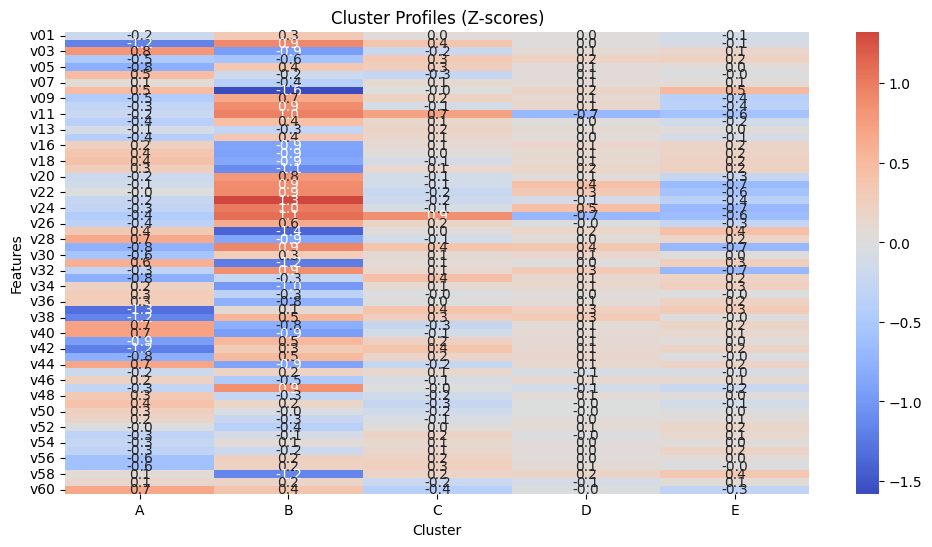

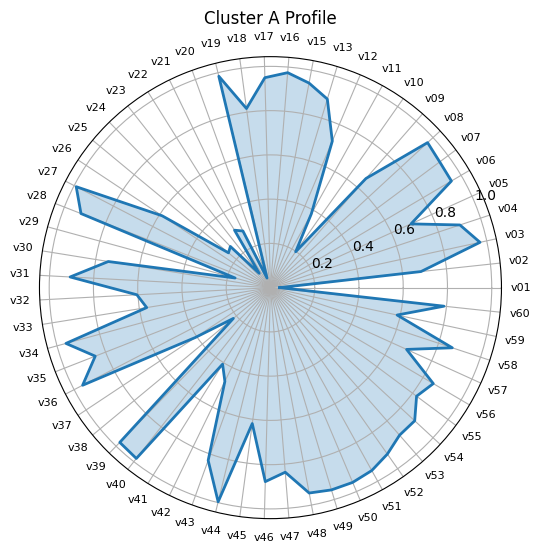

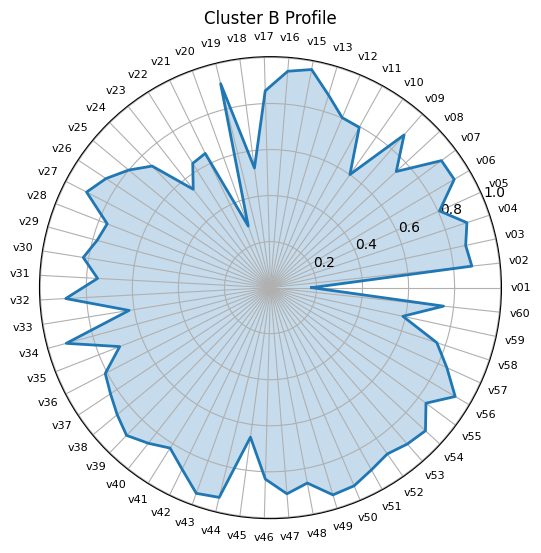

In [46]:
from math import pi

def radar_plot(cluster_id):
    values = cluster_means.loc[cluster_id].values.flatten().tolist()
    categories = list(cluster_means.columns)
    N = len(categories)

    values += values[:1]  # repeat first value
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'polar':True})
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=8)
    plt.title(f"Cluster {cluster_id} Profile")
    plt.show()

radar_plot("A")  # example for cluster 0
radar_plot("B")  # example for cluster 1


# Subclustering
For OAC the supergroup clusters created above are split further into groups and subgroups by applying the above process iteratively. This has the advantage of allowing more clusters to be created without needing to consider all clusters at once. It also allows for more interpretable clusters as the subclusters are nested within the broader supergroup clusters.

## Create Clustergrams for Subclusters

['A' 'B' 'C' 'D' 'E']
A
Cluster: A, 757 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_clusterA.png


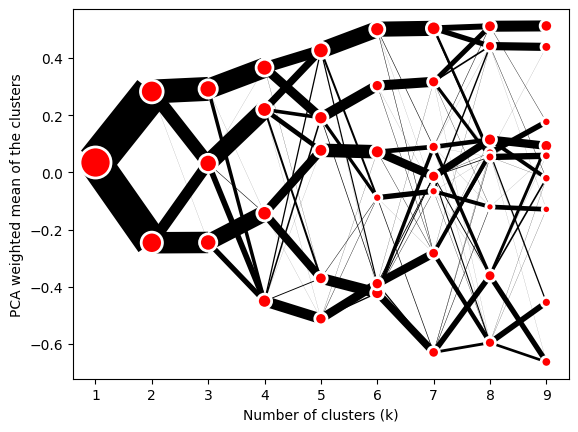

B
Cluster: B, 653 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_clusterB.png


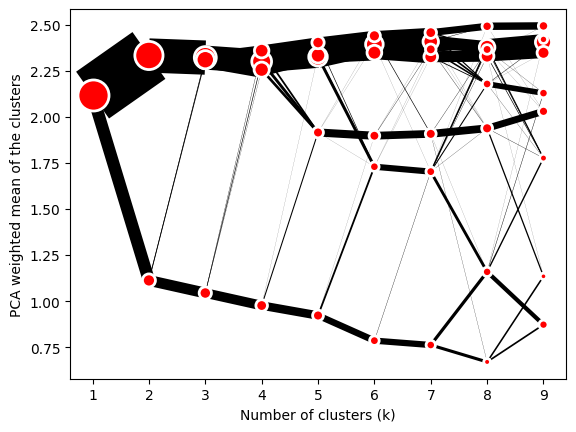

C
Cluster: C, 1024 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_clusterC.png


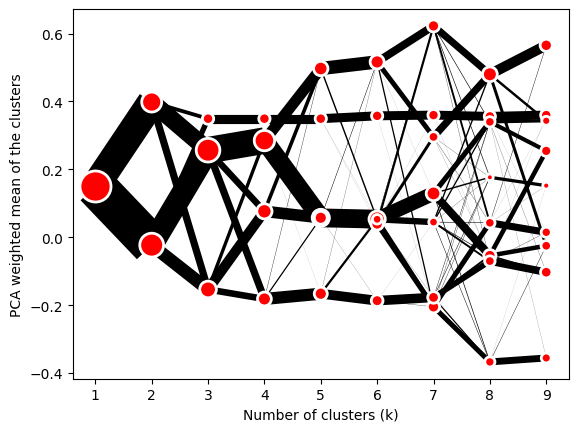

D
Cluster: D, 829 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_clusterD.png


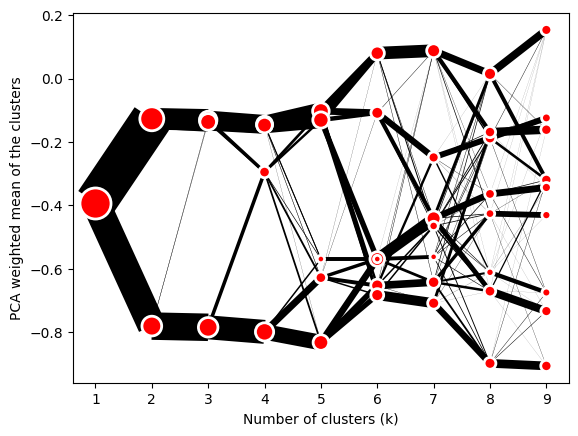

E
Cluster: E, 1061 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_clusterE.png


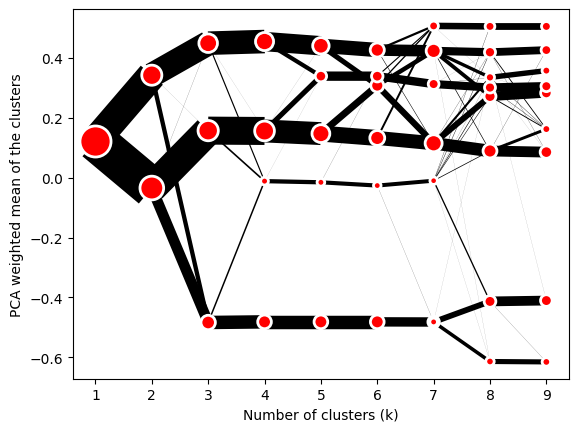

In [11]:
def create_subcluster_clustergrams(output_df, num_clusters, n_init=1):
    """
    Generate and save clustergrams for each supercluster.
    This function loops through the existing clusters and creates a clustergram 
    for each
    Parameters:
    output_df (pd.DataFrame): DataFrame containing cluster assignments.
    num_clusters (int): The total number of clusters to iterate over.
    n_init (int, optional): Number of times K-means runs with different centroid seeds.
                            Defaults to 1 for quick testing.

    """
    save_dir = "plots" #directory to save the clustergrams
    os.makedirs(save_dir, exist_ok=True)  # Ensure save directory exists
    cluster_labels = np.sort(output_df["cluster"].unique())
    print(cluster_labels)
    for cluster_label in cluster_labels:
        # Select rows corresponding to the current cluster, dropping the 'cluster' column
        print(cluster_label)
        cluster_df = output_df.query("cluster == @cluster_label").drop(columns='cluster')

        print(f"Cluster: {cluster_label}, {len(cluster_df)} geographies in cluster")

        if cluster_df.empty:
            print(f"Skipping cluster {cluster_label} as it has no data.")
            continue

        # Define save location
        save_loc = os.path.join(save_dir, f"subcluster_clustergram_cluster{cluster_label}.png")
        print(f"Saving clustergram to {save_loc}")

        # Generate clustergram
        create_clustergram(cluster_df, n_init=n_init, save_loc=save_loc)

# Example usage
create_subcluster_clustergrams(supergrouped_variable_df, num_clusters, n_init=1)



## Selecting the number of Subclusters
The clustergram below shows the results of applying k-means clustering to the supergroup A-E, f

In [12]:

def run_subclustering(input_df: pd.DataFrame, subcluster_nums: list, num_clusters: int, n_init: int = 1) -> pd.DataFrame:
    """
    Runs subclustering for each supergroup using KMeans and returns a modified DataFrame with subcluster labels.
    
    Parameters:
    - output_df (pd.DataFrame): The original DataFrame containing data and cluster assignments.
    - subcluster_nums (list): A list specifying the number of subclusters to split each supergroup into.
    - num_clusters (int): The total number of supergroups.
    - n_init (int, optional): The number of times KMeans will be initialized. Defaults to 1.

    Returns:
    - pd.DataFrame: A new the output dataFrame with an added 'subcluster' column.
    """

    cluster_labels = np.sort(input_df["cluster"].unique())
    print(f"Cluster labels found: {cluster_labels}")
    if len(subcluster_nums) != len(cluster_labels):
        raise ValueError(f"Length of subcluster_nums ({len(subcluster_nums)}) does not match num_clusters ({len(cluster_labels)}).")

    # Work on a copy of the DataFrame to prevent unintended modifications
    df = input_df.copy()

    for cluster, num_subclusters in zip(cluster_labels, subcluster_nums):
        print(f"Clustering supergroup {cluster} into {num_subclusters} subclusters.")

        # Select rows corresponding to the current cluster, drop the cluster column before clustering
        cluster_df = input_df.query("cluster == @cluster").drop(columns='cluster').copy()
        # Run KMeans clustering for the selected supergroup
        subcluster_output_df = run_kmeans(
            cluster_df, 
            num_subclusters, 
            n_init=n_init, 
            output_filepath=f"outputs/subclusters/supergroup{cluster}_subclusteroutput.csv"
        )

        # Combine anems
        subcluster_output_df['subcluster'] = [str(cluster) + str(i) for i in subcluster_output_df['cluster']]

        # Update the modified DataFrame with subclustering results
        df.loc[cluster_df.index, 'subcluster'] = subcluster_output_df['subcluster']

    # Save the final output
    df.to_csv("outputs/subgroups_clusteroutput.csv")
    print("Final output saved to outputs/subgroups_clusteroutput.csv")

    return df  # Return the modified DataFrame with clusters and subclusters


#run the subclustering for each of the supergroups
# We can now select the number of subclusters to split each of the supergroups into using the clustergrams above.
# For this example, we choose three subclusters for each supergroup.
# The length of the list must match num_clusters (the number of supergroups).
subcluster_nums = [5, 4, 2, 4, 2]
# subcluster_nums = [2, 4, 2, 2, 5, 2, 3, 3]

subgrouped_variable_df = run_subclustering(supergrouped_variable_df, subcluster_nums, num_clusters=num_clusters, n_init=1)


Cluster labels found: ['A' 'B' 'C' 'D' 'E']
Clustering supergroup A into 5 subclusters.
K-means clusters:
                cluster
Geography_Code         
E00032536             3
E00032538             3
E00032541             3
E00032546             1
E00032549             3
Clustering supergroup B into 4 subclusters.
K-means clusters:
                cluster
Geography_Code         
E00032537             0
E00032691             2
E00032693             2
E00032735             2
E00032746             0
Clustering supergroup C into 2 subclusters.
K-means clusters:
                cluster
Geography_Code         
E00032499             0
E00032500             1
E00032501             1
E00032504             1
E00032506             1
Clustering supergroup D into 4 subclusters.
K-means clusters:
                cluster
Geography_Code         
E00032508             2
E00032517             2
E00032520             3
E00032523             3
E00032540             3
Clustering supergroup E into 2 subcl

In [13]:
subcluster_nums = [5, 4, 2, 4, 2]

{'A1': '#63948b', 'A2': '#78b3a9', 'A3': '#8dd3c7', 'A4': '#a2f3e5', 'A5': '#b7ffff', 'B1': '#b2b27d', 'B2': '#d9d998', 'B3': '#ffffb3', 'B4': '#ffffce', 'C1': '#a29eb9', 'C2': '#bebada', 'D1': '#b05a50', 'D2': '#d56d61', 'D3': '#fb8072', 'D4': '#ff9383', 'E1': '#d79953', 'E2': '#fdb462'}


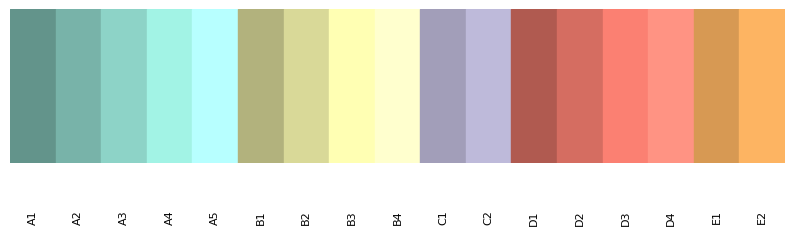

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to cluster_map.html!


In [ ]:
# Custom cluster colours for subclusters

from matplotlib import colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

def generate_shades(hex_color, n_shades=5, step=0.15):
    """Generate shades centred around a base color."""
    base = np.array(mcolors.to_rgb(hex_color))
    mid = n_shades // 2
    shades = []
    for i in range(n_shades):
        factor = 1 + (i - mid) * step
        shade = np.clip(base * factor, 0, 1)
        shades.append(mcolors.to_hex(shade))
    return shades

# Base cluster colours
base_colors = {
    "A": "#8dd3c7",
    "B": "#ffffb3",
    "C": "#bebada",
    "D": "#fb8072",
    "E": "#fdb462"
}


# Generate subgroup colours
colors = {}
for (group, hex_color), n_sub in zip(base_colors.items(), subcluster_nums):
    shades = generate_shades(hex_color, n_shades=n_sub)
    for i, shade in enumerate(shades, start=1):
        colors[f"{group}{i}"] = shade

# Example output dictionary
print(colors)

# Visualize palette
fig, ax = plt.subplots(figsize=(10, 2))
for i, (k, v) in enumerate(colors.items()):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=v))
    ax.text(i + 0.5, -0.3, k, ha='center', va='top', fontsize=8, rotation=90)
ax.set_xlim(0, len(colors))
ax.set_ylim(0, 1)
ax.axis("off")
plt.show()



sorted_clusters = sorted(colors.keys())
color_list = [colors[k] for k in sorted_clusters]

# # Ensure cluster column is string for Kepler
# supergrouped_variable_df["cluster"] = supergrouped_variable_df["cluster"].astype(str)
# #append geometry column from oas_liv to supergrouped_variable_df to make a geodataframe
gdf = oas_liv.merge(subgrouped_variable_df  , left_index=True, right_index=True, how='left')


# Config for polygons (fill only, no stroke)
config = {
    "version": "v1",
    "config": {
        "visState": {
            "filters": [],
            "layers": [
                {
                    "id": "clusters_layer",
                    "type": "geojson",   # polygon layer
                    "config": {
                        "dataId": "clusters",
                        "label": "Clusters",
                        'columns': {'geojson': 'geometry'},
                        "color": [130, 154, 227],
                        "highlightColor": [252, 242, 26, 255],
                        "isVisible": True,
                        "visConfig": {
                            "opacity": 0.8,
                            "thickness": 0,
                            "strokeColor": None,
                            "colorRange": {
                                "name": "Custom",
                                "type": "qualitative",
                                "category": "Custom",
                                "colors": color_list
                            },
                            "filled": True
                        },
                        "hidden": False,
                        "textLabel": []
                    },
                    "visualChannels": {
                        "colorField": {"name": "subcluster", "type": "string"},
                        "colorScale": "ordinal",
                        "strokeColorField": None,
                        "strokeColorScale": "quantile",
                        "sizeField": None,
                        "sizeScale": "linear"
                    }
                }
            ],
            "effects": [],
            "interactionConfig": {
                "tooltip": {
                    "fieldsToShow": {
                        "clusters": [
                            {"name": "subcluster", "format": None}
                        ]
                    },
                    "enabled": True
                }
            },
            "layerBlending": "normal"
        },
        "mapState": {
            "bearing": 0,
            "dragRotate": False,
            "latitude": 53.39056,
            "longitude": -2.90914,
            "pitch": 0,
            "zoom": 14.08,
            "isSplit": False
        },
        "mapStyle": {
            "styleType": "dark-matter",
            "topLayerGroups": {
                "water": True,
                "building": True
            },
            "visibleLayerGroups": {
                "label": True,
                "road": True,
                "border": False,
                "building": True,
                "water": True,
                "land": True,
                "3d building": False
            },
            "mapStyles": {
                "dark-matter": {
                    "id": "dark-matter",
                    "label": "Carto Dark Matter",
                    "url": "https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json"
                }
            }
        }
    }
}

# Show in Kepler
map_with_basemap = KeplerGl(data={"clusters":gdf}, config=config, height=600)
map_with_basemap.save_to_html(file_name="cluster_map.html")



In [15]:
subgrouped_variable_df 

,v01,v02,v03,v04,v05,v06,v07,v08,v09,v10,...,v53,v54,v55,v56,v57,v58,v59,v60,cluster,subcluster
Geography_Code,,,,,,,,,,,,,,,,,,,,,
E00032499,0.000000,0.814633,0.922883,0.947909,0.772049,0.931598,0.961374,0.938500,0.865961,0.000000,...,0.937442,0.938970,0.967981,0.932188,0.899363,0.894973,0.460515,0.511003,C,C0
E00032500,0.000000,0.884314,0.841518,0.967687,0.958383,0.883398,0.931459,0.540874,0.995554,0.726659,...,0.765952,0.921166,0.989894,0.980755,0.952934,0.907204,0.386497,0.677618,C,C1
E00032501,0.000000,0.845215,0.895586,0.945286,0.881100,0.887020,0.937257,0.969405,0.785365,0.000000,...,0.960611,0.955302,0.915131,0.953671,0.918883,0.857352,0.367180,0.528796,C,C1
E00032502,0.000000,0.874710,0.860319,0.955569,0.797332,0.922886,0.966344,0.969405,0.722991,0.783573,...,0.946458,0.961474,0.918883,0.947771,0.848092,0.870051,0.626194,0.511003,E,E0
E00032504,0.000000,0.824953,0.917563,0.934415,0.834096,0.864173,0.958839,0.969405,0.870306,0.000000,...,0.957862,0.945666,0.943322,0.970369,0.868312,0.907204,0.478261,0.511003,C,C1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
W00001367,0.000000,0.793602,0.922883,0.950497,0.821991,0.922886,0.948352,0.969405,0.856966,0.000000,...,0.946458,0.917404,0.965062,0.904329,0.848092,0.954681,0.512911,0.528796,D,D2
W00001583,0.920447,0.772025,0.943520,0.916848,0.772049,0.953050,0.953668,0.969405,0.837616,0.606496,...,0.957862,0.879874,0.956037,0.941687,0.770888,0.894973,0.529832,0.630123,C,C0
W00001589,0.000000,0.772025,0.948526,0.922886,0.797332,0.937192,0.966344,0.969405,0.856966,0.000000,...,0.921416,0.917404,0.952934,0.947771,0.806788,0.954681,0.610713,0.662003,D,D1


In [16]:
map_with_basemap

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'clusters_layer', '…